## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №30


#### Прогноз просрочки кредита заемщиком

Необходимо решить задачу просрочки кредита используя для прогнозирования нейронные сети.   
Рассмотреть работу с несбалансированными данными.  

Набор данных представляет собой исторические данные по 251503 заемщикам (https://www.kaggle.com/c/GiveMeSomeCredit/data ).  
Задача является бинарной классификацией. Цель - предсказать будет ли тот или иной заемщик испытывать финансовые трудности в ближайшие 2 года, т.е. будет ли просрочка по займу. Выборка разделена на тренировочную и тестовую ( 150000 в тренировочной части, 101503 в тестовой).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

RANDOM_STATE = 42

Загрузить набор данных из файла

In [2]:
col_dict = {
    # Целевая метка (1/0): будет ли просрочка платежей более 90 дней в ближайшие 2 года, Да/Нет
    'SeriousDlqin2yrs':'Delinquency',  
    # Баланс по кредитам (%): сумма всех кредитов за исключением недвижимости и рассрочек(автокредиты), разделенная на сумму кредитных лимитов
    'RevolvingUtilizationOfUnsecuredLines':'CreditBalance',
    # Возраст заемщика (лет)
    'age':'Age',
    # Количество просрочек платежей за последние 2 года: от 30 до 59 дней
    'NumberOfTime30-59DaysPastDueNotWorse':'Delay30_59',
    # Коэффициент задолженности (%): отношение суммы ежемесячных платежей (долги, алименты, проживание) к месячному доходу
    'DebtRatio':'DebtRatio',
    # Mесячный доход ($)
    'MonthlyIncome':'MonthlyIncome',
    # Количество открытых кредитов (рассрочек) и кредитных линий (кредитные карты)
    'NumberOfOpenCreditLinesAndLoans':'CreditLineNum',
    # Количество просрочек платежей за последние 2 года: 90 дней и больше
    'NumberOfTimes90DaysLate':'Delay90',
    # Количество открытых кредитов на недвижимость, включая кредитные линии под залог жилья
    'NumberRealEstateLoansOrLines':'EstateLoanNum',
    # Количество просрочек платежей за последние 2 года: от 60 до 89 дней
    'NumberOfTime60-89DaysPastDueNotWorse':'Delay60_89',
    # Количество иждивенцев в семье (исключая заемщика)
    'NumberOfDependents':'Dependents'
} 

df = pd.read_csv('cs-training.csv', index_col=0)
df.columns = [col_dict.get(x,x) for x in df.columns]
df = df[['Age','Dependents','MonthlyIncome','DebtRatio','CreditBalance','CreditLineNum','EstateLoanNum','Delay30_59','Delay60_89','Delay90','Delinquency']]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Age            150000 non-null  int64  
 1   Dependents     146076 non-null  float64
 2   MonthlyIncome  120269 non-null  float64
 3   DebtRatio      150000 non-null  float64
 4   CreditBalance  150000 non-null  float64
 5   CreditLineNum  150000 non-null  int64  
 6   EstateLoanNum  150000 non-null  int64  
 7   Delay30_59     150000 non-null  int64  
 8   Delay60_89     150000 non-null  int64  
 9   Delay90        150000 non-null  int64  
 10  Delinquency    150000 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


Проверить наличие NaN в значениях признаков, при необходимости осуществить замену  
Выполнить удаление дубликатов

In [3]:
# Для признака Dependents заменить все пустые значения на -1
df['Dependents'].fillna(-1, inplace=True)
# Для признака MonthlyIncome заменить все пустые значения на 0
df['MonthlyIncome'].fillna(0, inplace=True)

print(f'Количество записей-дубликатов: {df[df.duplicated()].shape[0]}')

# Удалить дубликаты сохраняя первую запись
df = df.drop_duplicates(keep='first')
print(f'Набор данных после удаления дубликатов: {df.shape}')

Количество записей-дубликатов: 648
Набор данных после удаления дубликатов: (149352, 11)


Построить корреляционную матрицу признаков  
Проанализировать зависимости

<AxesSubplot: >

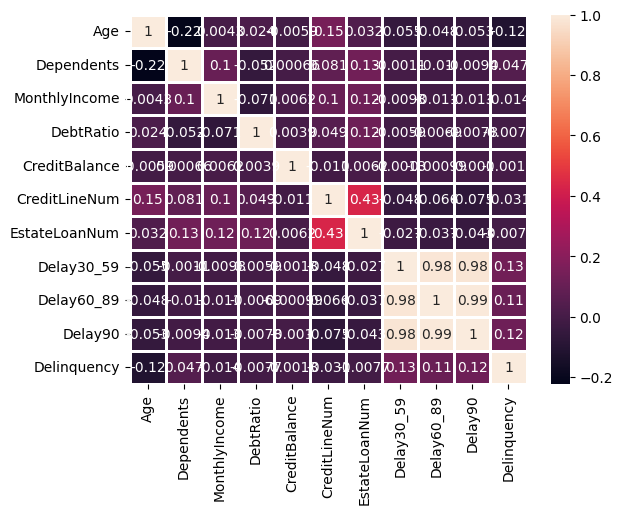

In [4]:
sns.heatmap(df.corr(), annot=True, linewidths=1)

- Наблюдается незначительная отрицательная корреляция (-0.22) признаков возраста (Age) и количества иждивенцев (Dependents)
- Наблюдается существенная положительная корреляция (0.43) между собой признаков количества открытых кредитов (CreditLineNum и EstateLoanNum)
- Наблюдается сильная корреляция (0.98 - 0.99) между собой признаков наличия просрочек платежей за различные периоды (Delay30_59, Delay60_89, Delay90)

In [5]:
# Заменить признаки CreditLineNum и EstateLoanNum на суммарный признак CreditNum
df.insert(7,'CreditNum', df.CreditLineNum + df.EstateLoanNum)
df.drop(['CreditLineNum','EstateLoanNum'], axis=1, inplace=True)

# Заменить признаки Delay30_59, Delay60_89 и Delay90 на суммарный признак DelayNum
df.insert(9,'DelayNum', df.Delay30_59 + df.Delay60_89 + df.Delay90)
df.drop(['Delay30_59','Delay60_89','Delay90'], axis=1, inplace=True)

In [6]:
# Визуализировать распределение значений признаков
df.describe(include = "all").T

,count,mean,std,min,25%,50%,75%,max
Age,149352.0,52.310153,14.722797,0.0,41.000000,52.000000,63.000000,109.0
Dependents,149352.0,0.714935,1.136387,-1.0,0.000000,0.000000,1.000000,20.0
MonthlyIncome,149352.0,5370.845780,13176.007265,0.0,1600.000000,4400.000000,7400.000000,3008750.0
DebtRatio,149352.0,354.529267,2042.102001,0.0,0.177571,0.368293,0.875665,329664.0
CreditBalance,149352.0,6.072551,250.296329,0.0,0.030150,0.154239,0.556414,50708.0
CreditNum,149352.0,9.505444,5.714916,0.0,5.000000,9.000000,13.000000,112.0
DelayNum,149352.0,0.840792,11.384862,0.0,0.000000,0.000000,0.000000,294.0
Delinquency,149352.0,0.067009,0.250039,0.0,0.000000,0.000000,0.000000,1.0


Визуализировать аномальные значения признаков

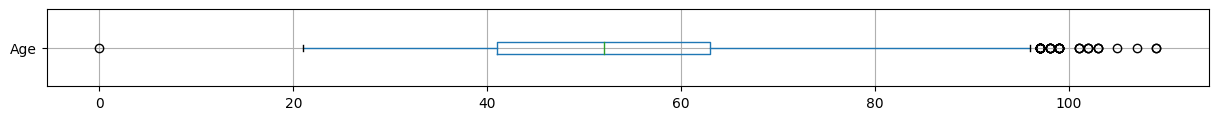

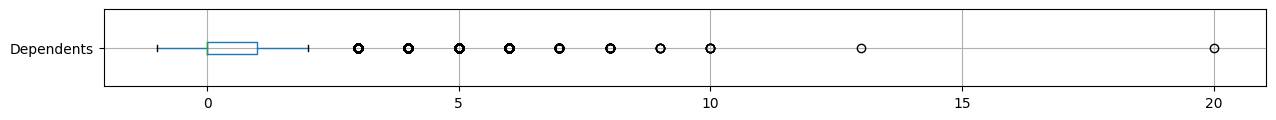

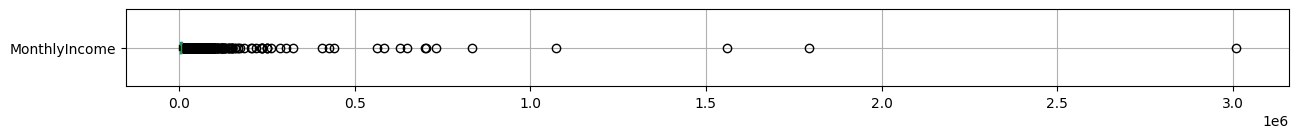

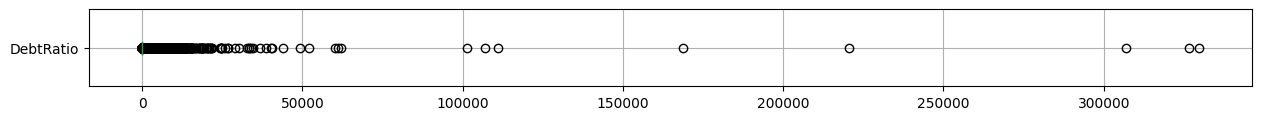

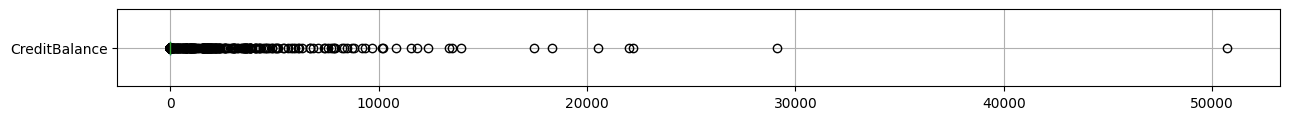

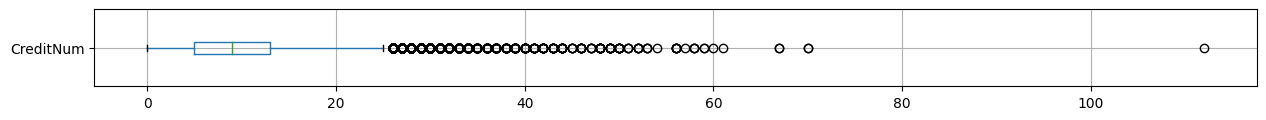

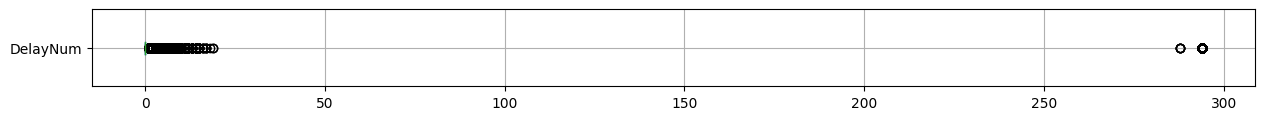

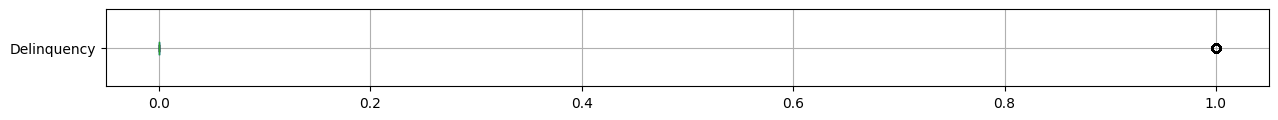

In [7]:
for col in df.columns:
    plt.figure(figsize=(15, 1))
    df[[col]].boxplot(vert=0 )

In [8]:
# Заменить нулевые значения возраста медианным значением
df['Age'].replace(0, df['Age'].median(), inplace=True) 

# Удалить записи с аномальными значениями признаков
df.drop(df[df.Dependents > 15].index, inplace=True)
df.drop(df[df.MonthlyIncome > 200000.0].index, inplace=True)
df.drop(df[df.DebtRatio > 22000.0].index, inplace=True)
df.drop(df[df.CreditBalance > 8000.0].index, inplace=True)
df.drop(df[df.CreditNum > 55].index, inplace=True)
df.drop(df[df.DelayNum > 50].index, inplace=True)

Оценить количество вернувших и не вернувших кредит

In [9]:
df['Delinquency'].value_counts()

0    139162
1      9862
Name: Delinquency, dtype: int64

Данные сильно несбалансированы. В качестве метрик лучше использовать `f1_score` или `roc_auc_score`. 

__Предобработка данных__

Выполнить нормализацию данных. Подготовить наборы данных для обучения и проверки

In [10]:
feat_cols = df.columns[:-1]

scaler = StandardScaler()

df[feat_cols] = scaler.fit_transform(df[feat_cols])

X = df[feat_cols].to_numpy()
y = df['Delinquency'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=RANDOM_STATE, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 0.2, random_state=RANDOM_STATE, stratify=y_train)

print(X_train.shape)
print(y_train.shape)

(95375, 7)
(95375,)


Определить собственные классы наборов данных PyTorch 

In [11]:
# train dataset
class TrainData(torch.utils.data.Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

# test dataset    
class TestData(torch.utils.data.Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [12]:
train_data = TrainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_data = TrainData(torch.FloatTensor(X_val), torch.FloatTensor(y_val))

test_data = TestData(torch.FloatTensor(X_test))

Определить собственный класс нейронной сети

In [13]:
class NeuralNet(nn.Module):
    
    def __init__(self, in_features=7, out_features=1):
        super().__init__()
        self.layer1 = nn.Linear(in_features=in_features, out_features=256)
        self.layer2 = nn.Linear(in_features=256, out_features=128)
        self.layer_out = nn.Linear(in_features=128, out_features=out_features)

        self.relu = nn.ReLU()
        #self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.batchnorm2 = nn.BatchNorm1d(128)

        
    def forward(self, inputs):
        x = self.relu(self.layer1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        #x = self.sigmoid(x)
        return x
    
# Функция вычисления метрики Accuracy бинарной классификации
def binary_acc(y_pred, y_true):
    y_pred_val = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = torch.eq(y_pred_val, y_true).sum().float()
    acc = correct_results_sum/y_true.shape[0]

    #acc = torch.round(acc * 100)   
    return acc

Определить функцию обучения модели нейронной сети

In [14]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    
    for epoch in range(1, epochs+1):
        
        model.train()
        train_loss, train_acc = 0.0, 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch.unsqueeze(1))
            acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() #* X_batch.size(0)
            train_acc += acc.item() #* X_batch.size(0)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        
        model.eval()
        val_loss, val_acc = 0.0, 0.0

        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch.unsqueeze(1))
            acc = acc = binary_acc(y_pred, y_batch.unsqueeze(1))

            val_loss += loss.item() #* X_batch.size(0)
            val_acc += acc.item() #* X_batch.size(0)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, Training accuracy = {:.5f}, Validation accuracy = {:.5f}'.format(
            epoch, train_loss, val_loss, train_acc, val_acc))

Определение констант и функций обучения модели

In [15]:
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.001

model1 = NeuralNet(in_features=7, out_features=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.NAdam(model1.parameters(), lr=LEARNING_RATE)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model1.to(device)
print(model1)

NeuralNet(
  (layer1): Linear(in_features=7, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Создать загрузчики наборов данных и выполнить обучение модели

In [16]:
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE) 

train(model1, optimizer, loss_fn, train_data_loader, val_data_loader, epochs=EPOCHS, device=device)

Epoch: 1, Training Loss: 0.23, Validation Loss: 0.19, Training accuracy = 0.92269, Validation accuracy = 0.93751
Epoch: 2, Training Loss: 0.19, Validation Loss: 0.19, Training accuracy = 0.93497, Validation accuracy = 0.93759
Epoch: 3, Training Loss: 0.19, Validation Loss: 0.19, Training accuracy = 0.93515, Validation accuracy = 0.93784
Epoch: 4, Training Loss: 0.19, Validation Loss: 0.19, Training accuracy = 0.93536, Validation accuracy = 0.93805
Epoch: 5, Training Loss: 0.19, Validation Loss: 0.19, Training accuracy = 0.93588, Validation accuracy = 0.93768
Epoch: 6, Training Loss: 0.19, Validation Loss: 0.18, Training accuracy = 0.93566, Validation accuracy = 0.93780
Epoch: 7, Training Loss: 0.19, Validation Loss: 0.18, Training accuracy = 0.93602, Validation accuracy = 0.93826
Epoch: 8, Training Loss: 0.18, Validation Loss: 0.18, Training accuracy = 0.93633, Validation accuracy = 0.93856
Epoch: 9, Training Loss: 0.18, Validation Loss: 0.18, Training accuracy = 0.93606, Validation ac

Выполнить оценку метрик обученной модели на тестовом наборе данных

In [17]:
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=1) 

y_pred_list = []
model1.eval()
with torch.no_grad():
    for X_batch in test_data_loader:
        
        X_batch = X_batch.to(device)
        y_test_pred = model1(X_batch)
   
        y_pred_tag = torch.round(torch.sigmoid(y_test_pred))
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [18]:
cm = confusion_matrix(y_test, y_pred_list)

print(cm)

print(f'Класс 0 - точность {cm[0,0]/sum(cm[0])}')
print(f'Класс 1 - точность {cm[1,1]/sum(cm[1])}')

[[27640   193]
 [ 1696   276]]
Класс 0 - точность 0.9930657852189847
Класс 1 - точность 0.13995943204868155


In [19]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27833
           1       0.59      0.14      0.23      1972

    accuracy                           0.94     29805
   macro avg       0.77      0.57      0.60     29805
weighted avg       0.92      0.94      0.92     29805



### Промежуточный вывод:  
Точность предсказания положительной оценки возврата займа очень-очень низкая!  
Очевидно - вследствии сильно несбалансированного набора данных

1. Попробуем сбалансировать наш обучающий набор данных с помощью WeightedRandomSampler

In [20]:
class_count=np.array([(y_train == 0).sum(),(y_train == 1).sum()])
print(class_count)
 
class_weight= 1./class_count #class_count/class_count.sum()
print(f'Веса классов в обучающем наборе: {class_weight}')

[89063  6312]
Веса классов в обучающем наборе: [1.12280071e-05 1.58428390e-04]


In [21]:
# Сформируем тензор весов классов обучающего набора 
samples_weight = np.array([class_weight[t] for t in y_train])
samples_weight=torch.from_numpy(samples_weight)

# Определим сэмплер формирования сбалансированного набора данных для обучения
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))

In [22]:
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.001

model2 = NeuralNet(in_features=7, out_features=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.NAdam(model2.parameters(), lr=LEARNING_RATE)

model2.to(device)

# Создадим загрузчик данных на базе обучающего набора и определеннго сэмплера
train2_data_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=BATCH_SIZE, sampler = sampler)

# Выполним обучение модели на обучающем наборе, сбалансированном с помощью WeightedRandomSampler
train(model2, optimizer, loss_fn, train2_data_loader, val_data_loader, epochs=EPOCHS, device=device)

Epoch: 1, Training Loss: 0.52, Validation Loss: 0.50, Training accuracy = 0.75211, Validation accuracy = 0.81421
Epoch: 2, Training Loss: 0.51, Validation Loss: 0.46, Training accuracy = 0.75479, Validation accuracy = 0.81861
Epoch: 3, Training Loss: 0.51, Validation Loss: 0.57, Training accuracy = 0.75720, Validation accuracy = 0.71153
Epoch: 4, Training Loss: 0.48, Validation Loss: 0.46, Training accuracy = 0.77181, Validation accuracy = 0.76776
Epoch: 5, Training Loss: 0.47, Validation Loss: 0.42, Training accuracy = 0.77711, Validation accuracy = 0.81299
Epoch: 6, Training Loss: 0.47, Validation Loss: 0.46, Training accuracy = 0.78147, Validation accuracy = 0.77558
Epoch: 7, Training Loss: 0.47, Validation Loss: 0.47, Training accuracy = 0.78194, Validation accuracy = 0.75866
Epoch: 8, Training Loss: 0.47, Validation Loss: 0.51, Training accuracy = 0.78184, Validation accuracy = 0.75432
Epoch: 9, Training Loss: 0.47, Validation Loss: 0.46, Training accuracy = 0.78078, Validation ac

Выполним оценку метрик обученной модели

In [23]:
y_pred2_list = []
model2.eval()
with torch.no_grad():
    for X_batch in test_data_loader:
        
        X_batch = X_batch.to(device)
        y_test_pred = model2(X_batch)
   
        y_pred_tag = torch.round(torch.sigmoid(y_test_pred))
        y_pred2_list.append(y_pred_tag.cpu().numpy())

y_pred2_list = [a.squeeze().tolist() for a in y_pred2_list]

In [24]:
cm = confusion_matrix(y_test, y_pred2_list)

print(cm)
print(f'Класс 0 - точность {cm[0,0]/sum(cm[0])}')
print(f'Класс 1 - точность {cm[1,1]/sum(cm[1])}')

[[22189  5644]
 [  510  1462]]
Класс 0 - точность 0.7972191283727948
Класс 1 - точность 0.7413793103448276


In [25]:
print(classification_report(y_test, y_pred2_list))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88     27833
           1       0.21      0.74      0.32      1972

    accuracy                           0.79     29805
   macro avg       0.59      0.77      0.60     29805
weighted avg       0.93      0.79      0.84     29805



2. Теперь попробуем вариант с параметром pos_weight функции потерь

pos_weight - отношение негативного класса к позитивному   
который передается в функцию потерь BCEWithLogitsLoss

In [32]:
class_weight= class_count/class_count.sum()

pos_weight = torch.tensor([class_weight[0]/class_weight[1]])
pos_weight

tensor([14.1101], dtype=torch.float64)

In [33]:
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.001

model3 = NeuralNet(in_features=7, out_features=1)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.NAdam(model3.parameters(), lr=LEARNING_RATE)

model3.to(device)

NeuralNet(
  (layer1): Linear(in_features=7, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [34]:
train3_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
train(model3, optimizer, loss_fn, train3_data_loader, val_data_loader, epochs=EPOCHS, device=device)

Epoch: 1, Training Loss: 0.99, Validation Loss: 0.93, Training accuracy = 0.76762, Validation accuracy = 0.80839
Epoch: 2, Training Loss: 0.97, Validation Loss: 0.94, Training accuracy = 0.78821, Validation accuracy = 0.80856
Epoch: 3, Training Loss: 0.96, Validation Loss: 0.94, Training accuracy = 0.78820, Validation accuracy = 0.81132
Epoch: 4, Training Loss: 0.96, Validation Loss: 0.93, Training accuracy = 0.78827, Validation accuracy = 0.81145
Epoch: 5, Training Loss: 0.95, Validation Loss: 0.92, Training accuracy = 0.78749, Validation accuracy = 0.80077
Epoch: 6, Training Loss: 0.91, Validation Loss: 0.87, Training accuracy = 0.78151, Validation accuracy = 0.77518
Epoch: 7, Training Loss: 0.90, Validation Loss: 0.87, Training accuracy = 0.77861, Validation accuracy = 0.79536
Epoch: 8, Training Loss: 0.89, Validation Loss: 0.87, Training accuracy = 0.77964, Validation accuracy = 0.79242
Epoch: 9, Training Loss: 0.89, Validation Loss: 0.88, Training accuracy = 0.78055, Validation ac

In [35]:
y_pred3_list = []
model3.eval()
with torch.no_grad():
    for X_batch in test_data_loader:
        
        X_batch = X_batch.to(device)
        y_test_pred = model3(X_batch)
   
        y_pred_tag = torch.round(torch.sigmoid(y_test_pred))
        y_pred3_list.append(y_pred_tag.cpu().numpy())

y_pred3_list = [a.squeeze().tolist() for a in y_pred3_list]

In [36]:
cm = confusion_matrix(y_test, y_pred3_list)

print(cm)
print(f'Класс 0 - точность {cm[0,0]/sum(cm[0])}')
print(f'Класс 1 - точность {cm[1,1]/sum(cm[1])}')

[[22491  5342]
 [  517  1455]]
Класс 0 - точность 0.8080695577192542
Класс 1 - точность 0.7378296146044625


In [37]:
print(classification_report(y_test, y_pred3_list))

              precision    recall  f1-score   support

           0       0.98      0.81      0.88     27833
           1       0.21      0.74      0.33      1972

    accuracy                           0.80     29805
   macro avg       0.60      0.77      0.61     29805
weighted avg       0.93      0.80      0.85     29805



### Вывод:
Ну, вроде как и ресэмплинг обучающего набора и добавление веса для позитивного класса в функцию потерь - оба метода помогают улучшить точность предсказания положительных решений (примерно одинаково)